In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from influxdb import *
import datetime                        
import matplotlib.pyplot as plt                    # plots
import seaborn as sns                              # more plots
from dateutil.relativedelta import relativedelta   # working with dates with style
from scipy.optimize import minimize                # for function minimization
import statsmodels.formula.api as smf              # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                      # some useful functions
#from tqdm import tqdm_notebook
%matplotlib inline
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
#from mlxtend.regressor import LinearRegression

In [2]:
data = pd.read_excel (r'C:\Users\u22v09\Desktop\One_hr_agg_Data.xlsx') 
data=data.set_index('time')

In [3]:
data.head()

,EM1,EM10,EM2,EM22,EM23,EM3,EM4,EM5,EM6,EM7,EM8,EM9
time,,,,,,,,,,,,
2020-06-15 01:00:00,995,38.8,0,3.6,0.0,0,363,272,0.6,0.0,80.2,49.3
2020-06-15 02:00:00,76,2.9,0,0.3,0.0,0,19,25,0.1,0.0,6.1,3.4
2020-06-15 04:00:00,1067,40.5,0,2.7,15.6,0,270,313,0.8,0.0,68.8,48.0
2020-06-15 05:00:00,1208,47.5,0,3.8,24.7,0,250,337,0.4,0.1,79.8,57.4
2020-06-15 06:00:00,1260,47.2,0,3.8,41.2,0,293,384,0.0,0.1,79.3,55.0


In [4]:
EM4=data[["EM4"]]

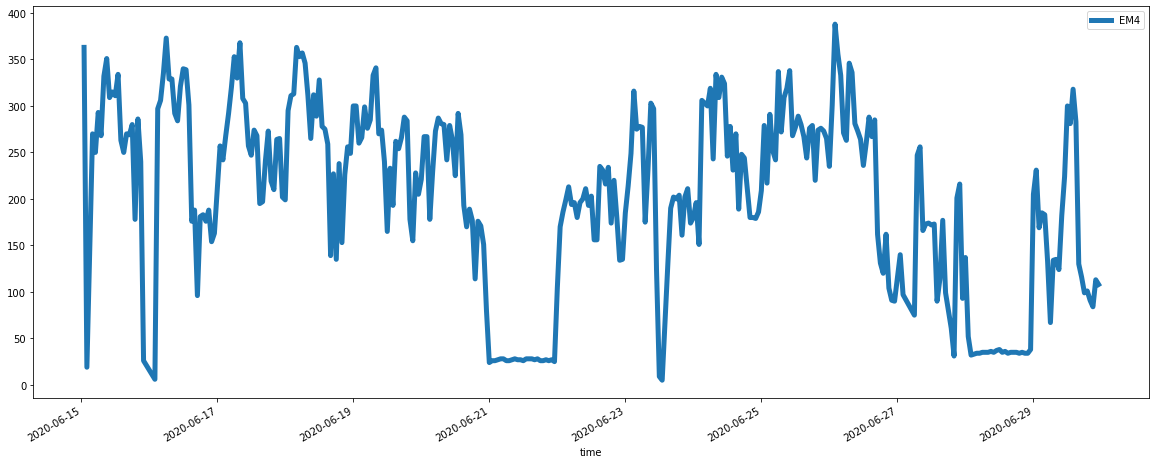

In [5]:
EM4['Date'] = [d.date() for d in EM4.index]
EM4.plot(figsize = (20,8), lw = 5)

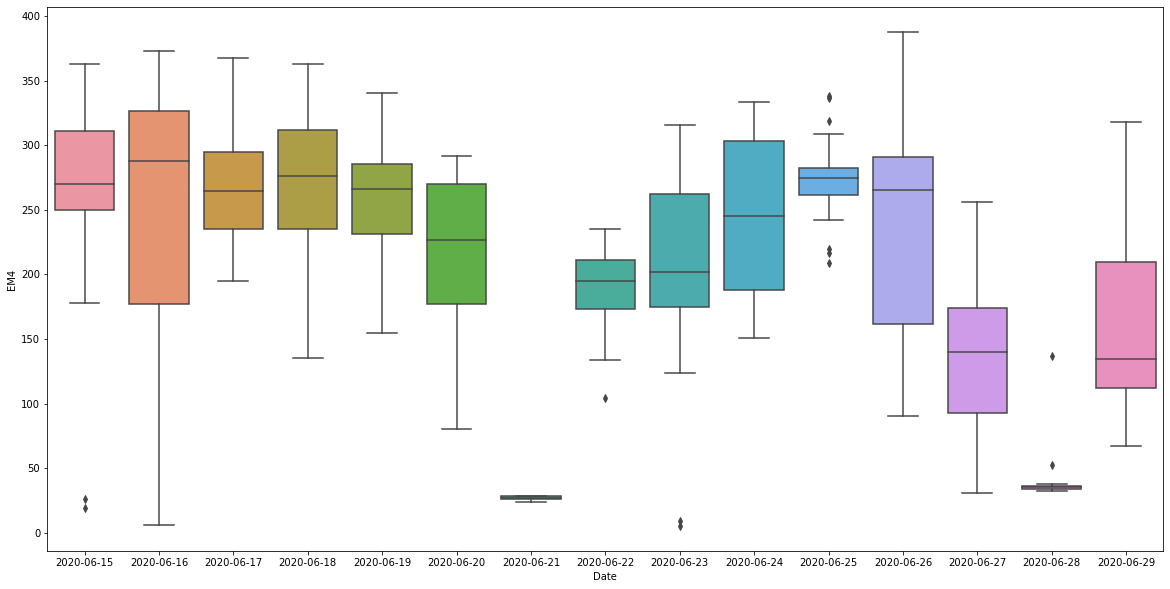

In [6]:
plt.figure(figsize=(20,10))
EM4['Date'] = [d.date() for d in EM4.index]
sns.boxplot(x="Date", y="EM4",data=EM4)

# Anomilies Detection

In [7]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.645, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(20,8))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend", lw = 3)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond", lw = 2)
        plt.plot(lower_bond, "r--", lw = 2)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values", lw = 3)
    plt.legend(loc="upper left")
    plt.grid(True)

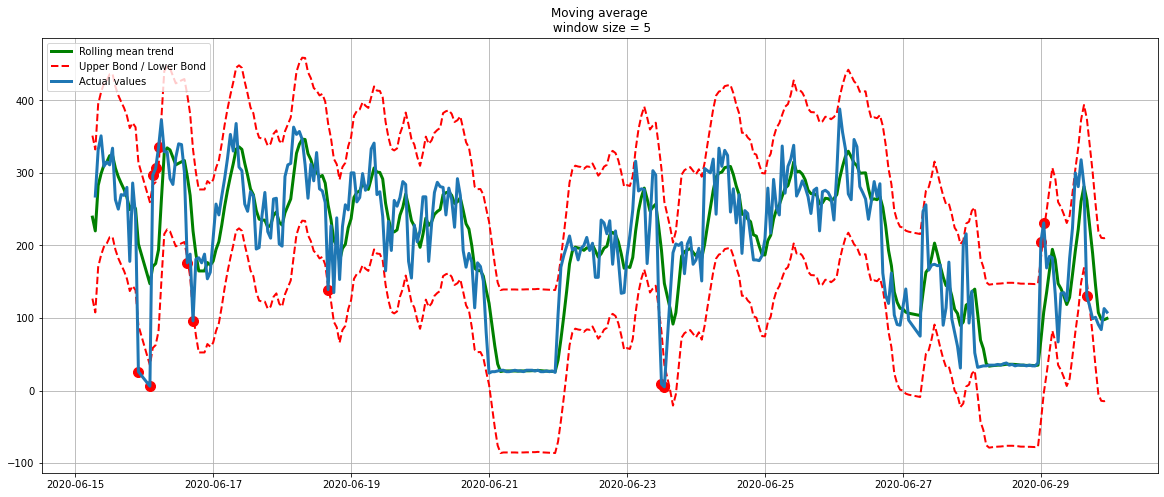

In [9]:
energy_anomaly = pd.DataFrame(EM4['EM4'].copy())
plotMovingAverage(energy_anomaly, 5, plot_intervals=True, plot_anomalies=True)

# Removing Only the anomalies

In [10]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
data2 = EM4.copy()
energy_anomaly = pd.DataFrame(data2['EM4'])
rolling_mean = energy_anomaly.rolling(window=5).mean()
mae = mean_absolute_error(energy_anomaly[5:], rolling_mean[5:])
deviation = np.std(energy_anomaly[5:] - rolling_mean[5:])
lower_bond = rolling_mean - (mae + 1.645 * deviation)
upper_bond = rolling_mean + (mae + 1.645 * deviation)
anomalies = pd.DataFrame(index = energy_anomaly.index, columns = energy_anomaly.columns)
anomalies[energy_anomaly<lower_bond] = energy_anomaly[energy_anomaly<lower_bond]
anomalies[energy_anomaly>upper_bond] = energy_anomaly[energy_anomaly>upper_bond]
anomalies = anomalies.dropna()

In [12]:
len(anomalies)

13

In [13]:
data2.loc[anomalies.index,'EM4'] = np.nan 

In [14]:
# For Anomalies
# Linear Interpolation
new1_data2 = data2.interpolate()
# new1_data2['EM4'].plot(figsize = (20,6), linewidth = 5, grid = True)

In [15]:
# For Anomalies
# Time Interpolation
new2_data2 = data2.interpolate(method = 'time')
# new2_data2['EM4'].plot(figsize = (20,6), linewidth = 5, grid = True)

In [16]:
# For Anomalies
# Cubic Interpolation
new3_data2 = data2.interpolate(method = 'cubic')
# new3_data2['EM4'].plot(figsize = (20,6), linewidth = 5, grid = True)

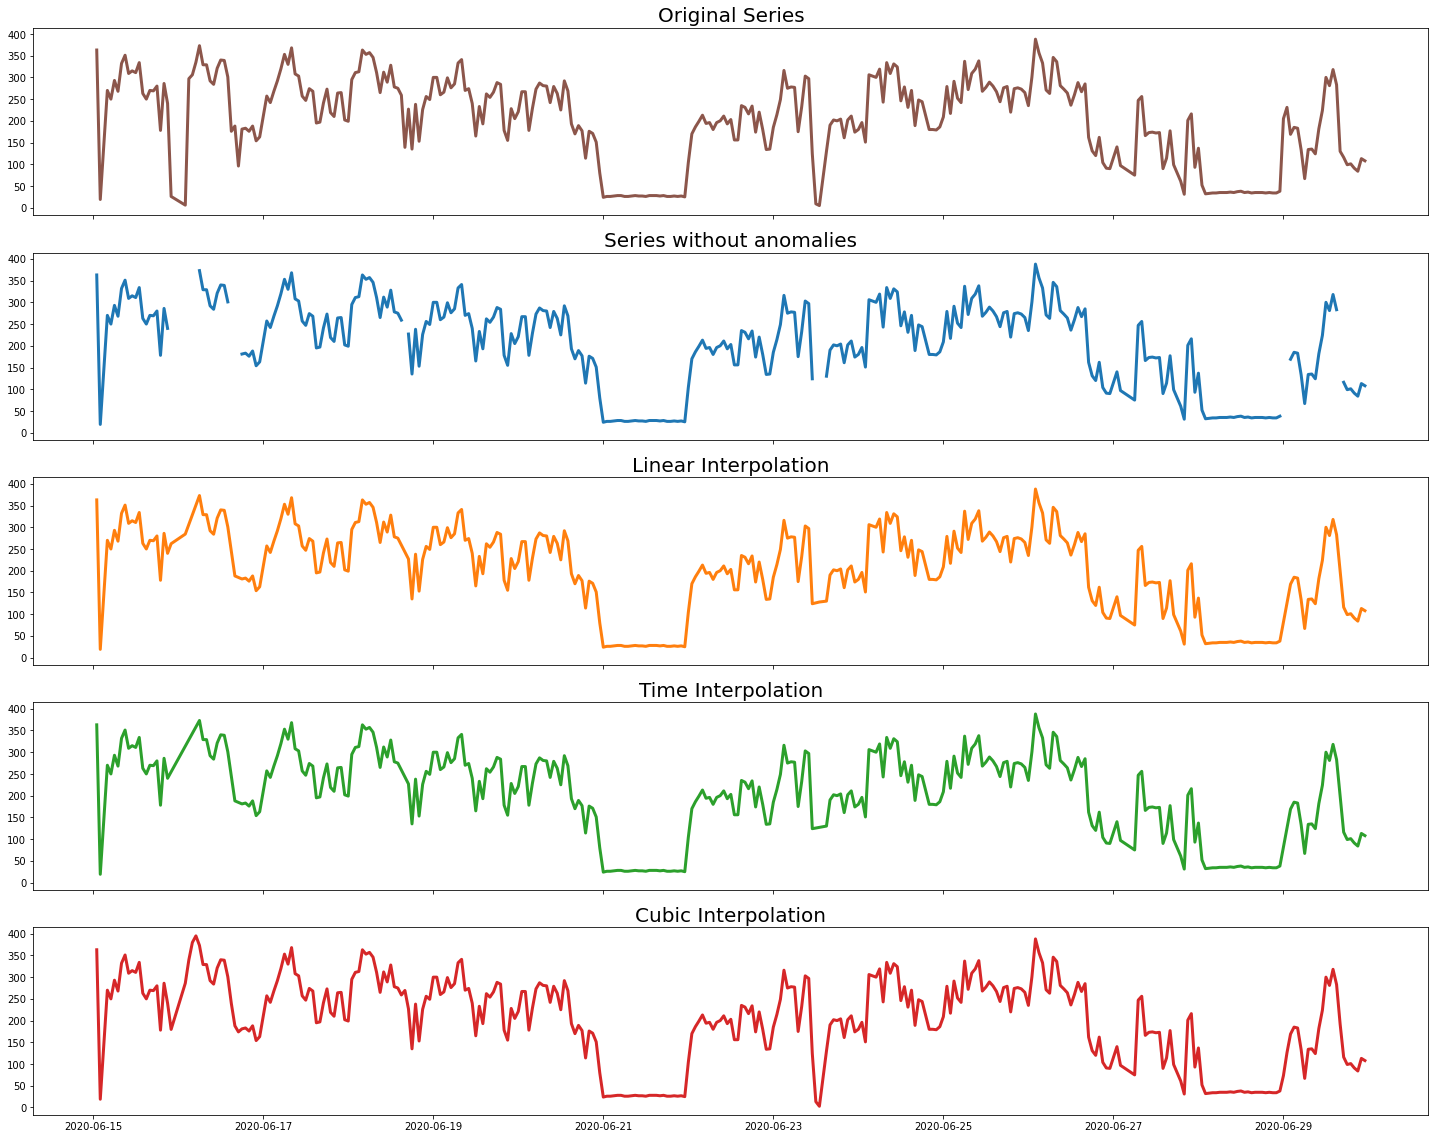

In [17]:
fig, axs = plt.subplots(5, sharex=True, sharey=True, gridspec_kw={'hspace': 0.2}, figsize=(25,20))
# fig.suptitle('Interpolated Series', va = 'bottom', ha = 'center', fontsize = 50)
axs[0].plot(EM4.index, EM4['EM4'], 'tab:brown', linewidth = 3)
axs[0].set_title('Original Series', fontsize = 20)
axs[1].plot(data2.index, data2['EM4'], 'tab:blue', linewidth = 3)
axs[1].set_title('Series without anomalies', fontsize = 20)
axs[2].plot(new1_data2.index, new1_data2['EM4'], 'tab:orange', linewidth = 3)
axs[2].set_title('Linear Interpolation', fontsize = 20)
axs[3].plot(new2_data2.index, new2_data2['EM4'], 'tab:green', linewidth = 3)
axs[3].set_title('Time Interpolation', fontsize = 20)
axs[4].plot(new3_data2.index, new3_data2['EM4'], 'tab:red', linewidth = 3)
axs[4].set_title('Cubic Interpolation', fontsize = 20)

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [18]:
# Linear Interpolation
from statsmodels.tsa.stattools import adfuller
result_o = adfuller(EM4['EM4'])
result_l = adfuller(new1_data2['EM4'])
result_t = adfuller(new2_data2['EM4'])
result_c = adfuller(new3_data2['EM4'])

In [19]:
P_value = [result_o[1], result_l[1], result_t[1], result_c[1]]
ADF_Statistics = [result_o[0], result_l[0], result_t[0], result_c[0]]
Result = pd.DataFrame(P_value, ADF_Statistics).reset_index()
Result = Result.rename(columns={'index': 'ADF Statistics', 0: 'P-Value'})
Result = Result.T
Result = Result.rename(columns={0: 'Original', 1: 'Linear', 2: 'Time', 3: 'Cubic'})
Result

,Original,Linear,Time,Cubic
ADF Statistics,-3.989215,-3.375453,-3.366116,-3.178828
P-Value,0.001468,0.011825,0.012170,0.021243


# Considering series with cubic interpolation for further analysis as it has least p-value and highest negative ADF Statistics value which makes it more stationary than the other series

In [20]:
# new3_data2 = data2.interpolate(method = 'cubic')
EM4_cubic = new3_data2.copy()
EM4_cubic = EM4_cubic.drop(['Date'], axis = 1)
EM4_cubic.head()

,EM4
time,
2020-06-15 01:00:00,363.0
2020-06-15 02:00:00,19.0
2020-06-15 04:00:00,270.0
2020-06-15 05:00:00,250.0
2020-06-15 06:00:00,293.0


In [21]:
EM4_cubic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 351 entries, 2020-06-15 01:00:00 to 2020-06-29 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EM4     351 non-null    float64
dtypes: float64(1)
memory usage: 5.5 KB


In [22]:
x = (len(EM4_cubic))*0.9
x

315.90000000000003

In [23]:
EM4_cubic.iloc[330]

EM4    185.0
Name: 2020-06-29 03:00:00, dtype: float64

In [24]:
#Creating train and test set 
#Index 446 marks 24th June 2020 16:00
train = EM4_cubic[0:330] 
test = EM4_cubic[329:]

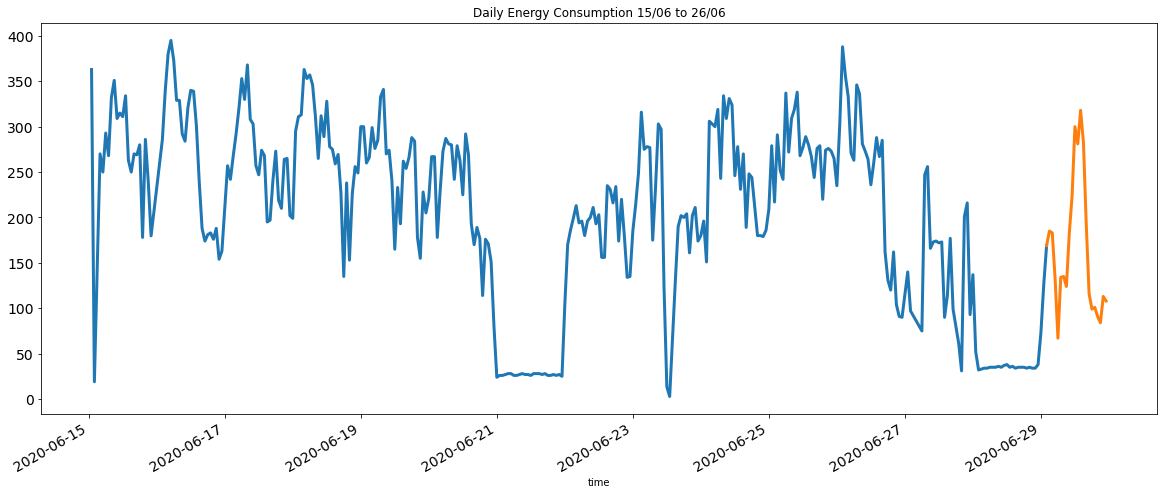

In [25]:
# Let’s visualize the data (train and test together) to know how it varies over a time period.
# Plotting data
train.EM4.plot(figsize=(20,8), title= 'Daily Energy Consumption 15/06 to 26/06', fontsize=14, lw = 3)
test.EM4.plot(figsize=(20,8), title= 'Daily Energy Consumption 15/06 to 26/06', fontsize=14, lw = 3)
plt.show()

# Method 1 – Simple average



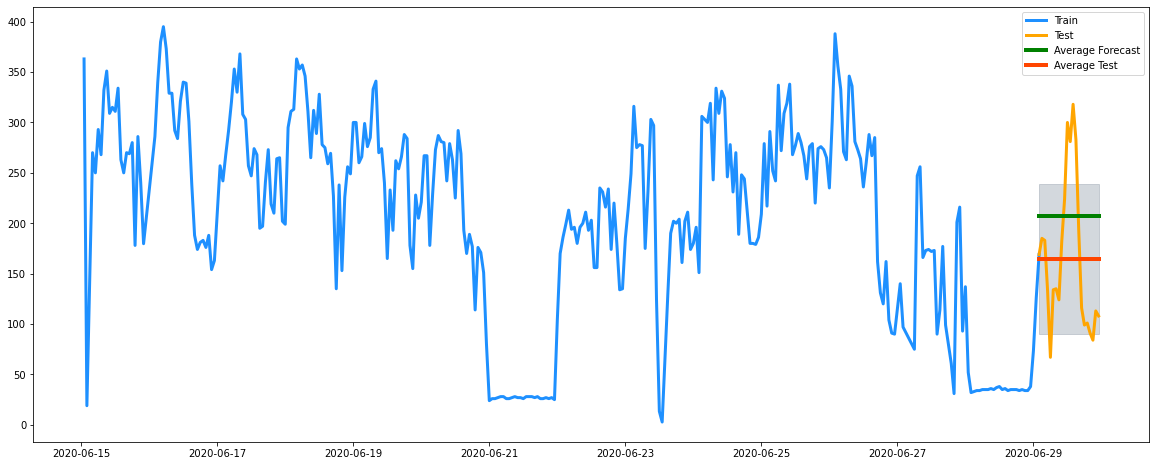

84.49713679531044


In [26]:
from statistics import stdev 

y_hat_avg = test.copy()

y_hat_avg['avg_forecast'] = train['EM4'].mean()
y_hat_avg['test_mean'] = test['EM4'].mean()
y_hat_avg['test_sd'] = stdev(test['EM4'])
y_hat_avg['-SD']=y_hat_avg['test_mean']-y_hat_avg['test_sd']
y_hat_avg['+SD']=y_hat_avg['test_mean']+y_hat_avg['test_sd']
# with plt.style.context('classic'):
plt.figure(figsize=(20,8))
plt.plot(train['EM4'], label = 'Train', lw = 3,color='dodgerblue')
plt.plot(test['EM4'], label = 'Test', lw = 3,color='orange')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast', lw = 4,color='green')
plt.plot(y_hat_avg['test_mean'], label='Average Test', lw = 4,color='orangered')
plt.legend(loc = 'best')
plt.fill_between(y_hat_avg.index,y_hat_avg['-SD'], y_hat_avg['+SD'],alpha=0.3,color='slategrey')
#plt.style.use('classic')
plt.show()
rms1 = sqrt(mean_squared_error(test.EM4, y_hat_avg.avg_forecast))
print(rms1)

In [27]:
 
y_hat_avg['test_sd'] = stdev(test['EM4'])

In [28]:
y_hat_avg['+SD']=y_hat_avg['test_mean']-y_hat_avg['test_sd']

In [29]:
# plt.style.use('ggplot') #Change/Remove This If you Want

# fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(test, EM4.mean(axis=1), alpha=0.5, color='blue', label='train', linewidth = 4.0)
# #ax.plot(y_hat_avg, avg_forecast.mean(axis=1), alpha=0.5, color='red', label='cv', linewidth = 1.0)
# ax.fill_between(test.index, test.EM4.mean(axis=1) - test.EM4.std(axis=1), test.EM4.mean(axis=1) + test.EM4.std(axis=1), color='#888888', alpha=0.4)
# ax.fill_between(test.index, test.EM4.mean(axis=1) - 2*test.EM4.std(axis=1), test.EM4.mean(axis=1) + 2*test.EM4.std(axis=1), color='#888888', alpha=0.2)
# ax.legend(loc='best')
# ax.set_ylim([0.88,1.02])
# ax.set_ylabel("Accuracy")
# ax.set_xlabel("N_estimators")

# Method 2 - Moving Average

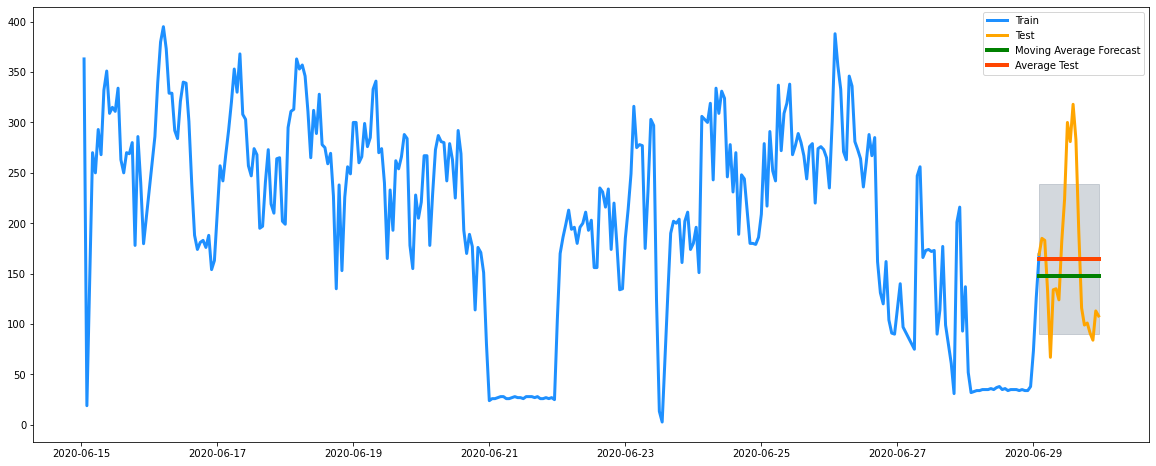

74.99054860452814


In [30]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['EM4'].rolling(2).mean().iloc[-1]
y_hat_avg['test_mean'] = test['EM4'].mean()
y_hat_avg['test_sd'] = stdev(test['EM4'])
y_hat_avg['-SD']=y_hat_avg['test_mean']-y_hat_avg['test_sd']
y_hat_avg['+SD']=y_hat_avg['test_mean']+y_hat_avg['test_sd']
plt.figure(figsize=(20,8))
plt.plot(train['EM4'], label = 'Train', lw = 3,color='dodgerblue')
plt.plot(test['EM4'], label = 'Test', lw = 3,color='orange')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast', lw = 4,color='green')
plt.plot(y_hat_avg['test_mean'], label='Average Test', lw = 4,color='orangered')
plt.legend(loc = 'best')
plt.fill_between(y_hat_avg.index,y_hat_avg['-SD'], y_hat_avg['+SD'],alpha=0.3,color='slategrey')
plt.show()
rms2 = sqrt(mean_squared_error(test.EM4, y_hat_avg.moving_avg_forecast))
print(rms2)

# Method 3 - Naive Method

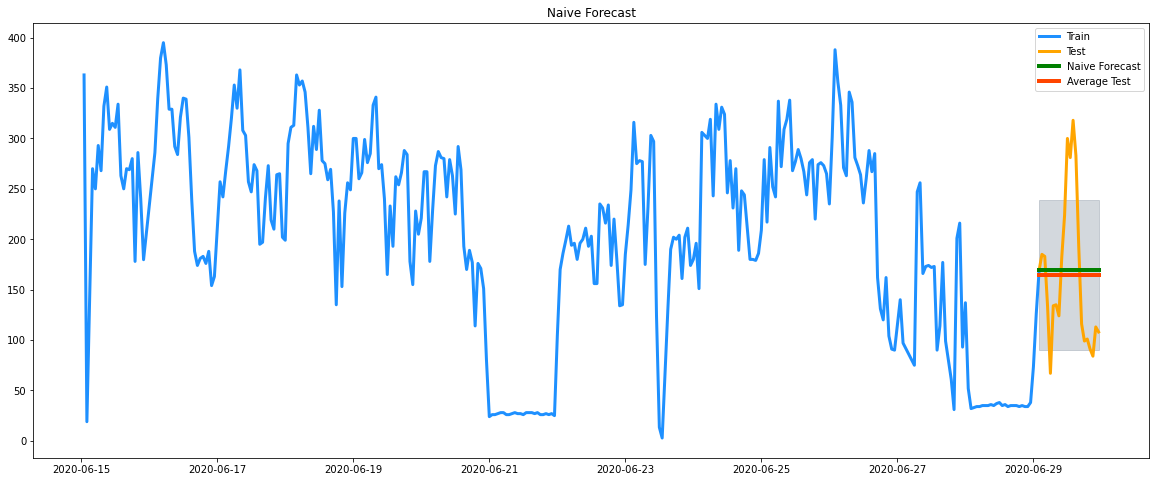

73.14118954673827


In [31]:
dd= np.asarray(train.EM4)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
y_hat['test_mean'] = test['EM4'].mean()
y_hat['test_sd'] = stdev(test['EM4'])
y_hat['-SD']=y_hat['test_mean']-y_hat['test_sd']
y_hat['+SD']=y_hat['test_mean']+y_hat['test_sd']
plt.figure(figsize=(20,8))
plt.plot(train.index, train['EM4'], label='Train', lw = 3,color='dodgerblue')
plt.plot(test.index,test['EM4'], label='Test', lw = 3,color='orange')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast', lw = 4,color='green')
plt.plot(y_hat['test_mean'], label='Average Test', lw = 4,color='orangered')
plt.fill_between(y_hat.index,y_hat['-SD'], y_hat['+SD'],alpha=0.3,color='slategrey')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()
rms3 = sqrt(mean_squared_error(test.EM4, y_hat.naive))
print(rms3)

# Method 4 – Single Exponential smoothing



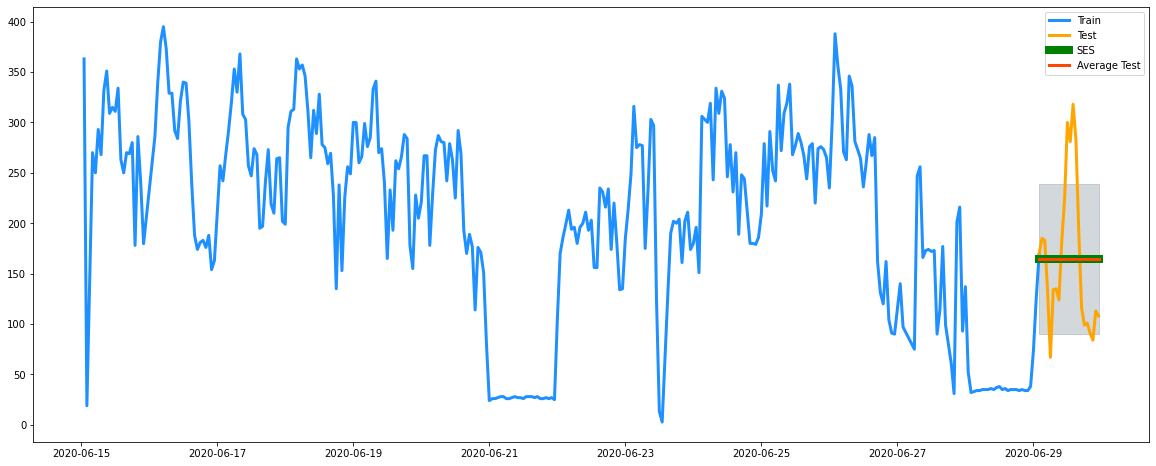

73.0132169169795


In [32]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['EM4'])).fit(smoothing_level = 0.9, optimized = False)
y_hat_avg['SES'] = fit2.forecast(len(test))
y_hat_avg['test_mean'] = test['EM4'].mean()
y_hat_avg['test_sd'] = stdev(test['EM4'])
y_hat_avg['-SD']=y_hat_avg['test_mean']-y_hat_avg['test_sd']
y_hat_avg['+SD']=y_hat_avg['test_mean']+y_hat_avg['test_sd']
plt.figure(figsize=(20,8))
plt.plot(train['EM4'], label='Train', lw =3,color='dodgerblue')
plt.plot(test['EM4'], label='Test', lw =3,color='orange')
plt.plot(y_hat_avg['SES'], label='SES', lw = 8,color='green')
plt.plot(y_hat_avg['test_mean'], label='Average Test', lw = 3,color='orangered')
plt.fill_between(y_hat_avg.index,y_hat_avg['-SD'], y_hat_avg['+SD'],alpha=0.3,color='slategrey')
plt.legend(loc='best')
plt.show()
rms4 = sqrt(mean_squared_error(test.EM4, y_hat_avg.SES))
print(rms4)

In [33]:
# y_hat_avg['SES']

In [34]:
# test['predicted']=y_hat_avg['SES']
# test

# Method 5 - Holt’s Linear Trend method

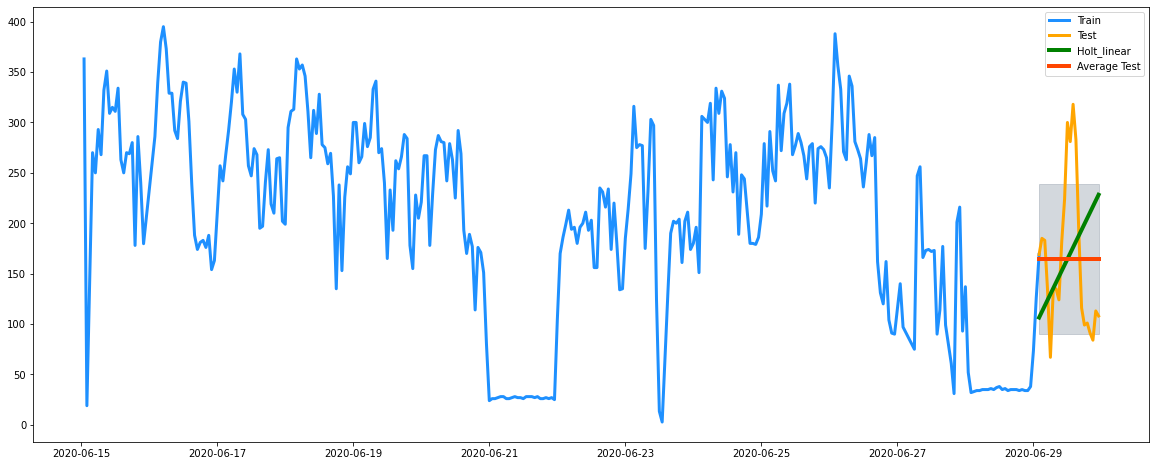

87.75903411452519


In [35]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['EM4'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))
y_hat_avg['test_mean'] = test['EM4'].mean()
y_hat_avg['test_sd'] = stdev(test['EM4'])
y_hat_avg['-SD']=y_hat_avg['test_mean']-y_hat_avg['test_sd']
y_hat_avg['+SD']=y_hat_avg['test_mean']+y_hat_avg['test_sd']
plt.figure(figsize=(20,8))
plt.plot(train['EM4'], label='Train',lw=3,color='dodgerblue')
plt.plot(test['EM4'], label='Test',lw=3,color='orange')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear',lw=4,color='green')
plt.plot(y_hat_avg['test_mean'], label='Average Test', lw = 4,color='orangered')
plt.fill_between(y_hat_avg.index,y_hat_avg['-SD'], y_hat_avg['+SD'],alpha=0.3,color='slategrey')
plt.legend(loc='best')
plt.show()
rms5 = sqrt(mean_squared_error(test.EM4, y_hat_avg.Holt_linear))
print(rms5)

# Method 6 – Holt’s Winter seasonal method

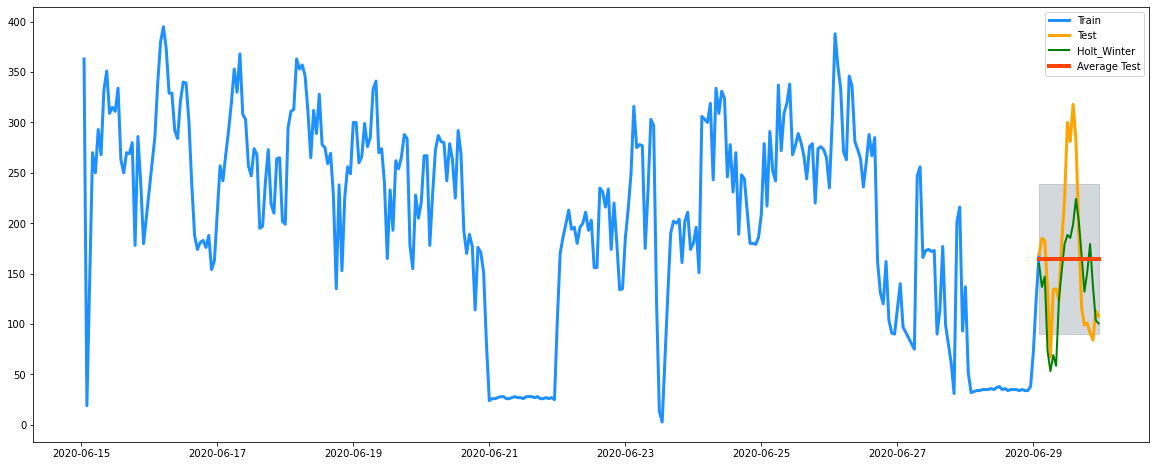

59.125347113592014


In [36]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['EM4']) ,seasonal_periods = 83, trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
y_hat_avg['test_mean'] = test['EM4'].mean()
y_hat_avg['test_sd'] = stdev(test['EM4'])
y_hat_avg['-SD']=y_hat_avg['test_mean']-y_hat_avg['test_sd']
y_hat_avg['+SD']=y_hat_avg['test_mean']+y_hat_avg['test_sd']
plt.figure(figsize=(20,8))
plt.plot( train['EM4'], label='Train', lw = 3,color='dodgerblue')
plt.plot(test['EM4'], label='Test', lw = 3,color='orange')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter', lw = 2,color='green')
plt.plot(y_hat_avg['test_mean'], label='Average Test', lw = 4,color='orangered')
plt.fill_between(y_hat_avg.index,y_hat_avg['-SD'], y_hat_avg['+SD'],alpha=0.3,color='slategrey')
plt.legend(loc='best')
plt.show()
rms6 = sqrt(mean_squared_error(test.EM4, y_hat_avg.Holt_Winter))
print(rms6)

In [37]:
x=pd.DataFrame([rms1,rms2,rms3,rms4,rms5,rms6]).T
x.columns=["Simple Average","Moving Average","Naive","SES","Holt's Linear","Holt's Winter"]

In [38]:
x

,Simple Average,Moving Average,Naive,SES,Holt's Linear,Holt's Winter
0,84.497137,74.990549,73.14119,73.013217,87.759034,59.125347


<BarContainer object of 6 artists>

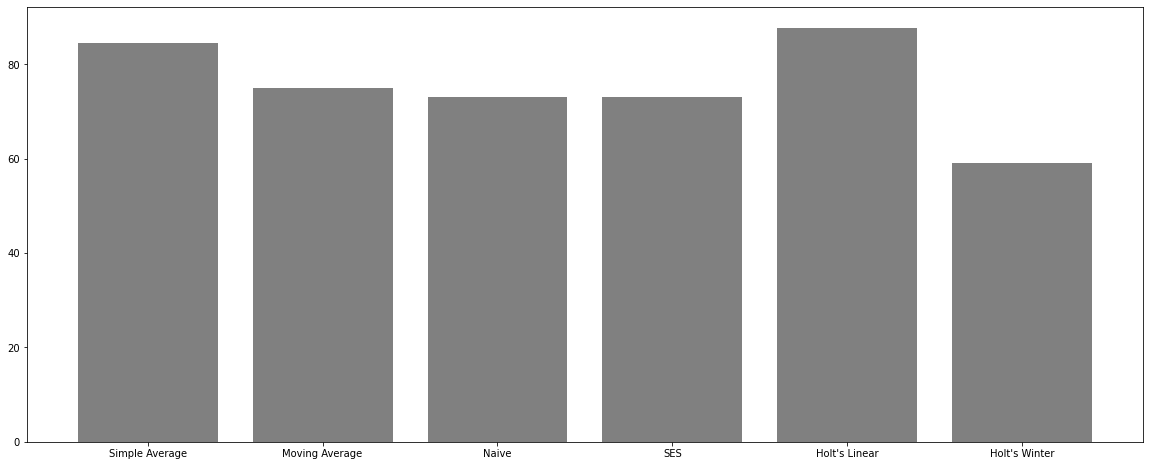

In [39]:
t=x.T
t=t.rename(columns={0: 'RMS'})
fig, ax1 = plt.subplots(figsize = (20,8))
ax1.bar(t.index,t.RMS, color = 'grey')

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
l=[]
for i in range(2,100):
    fit1 = ExponentialSmoothing(np.asarray(train['EM4']) ,seasonal_periods = i, trend='add', seasonal='add').fit()
    x = fit1.forecast(len(test))
    rms = sqrt(mean_squared_error(test.EM4, x))
    l.append(rms)

In [42]:
y=pd.DataFrame(l)
y.reset_index()
y.min()
# y[y[0]<=y[0].min()*1.25]

0    59.125347
dtype: float64

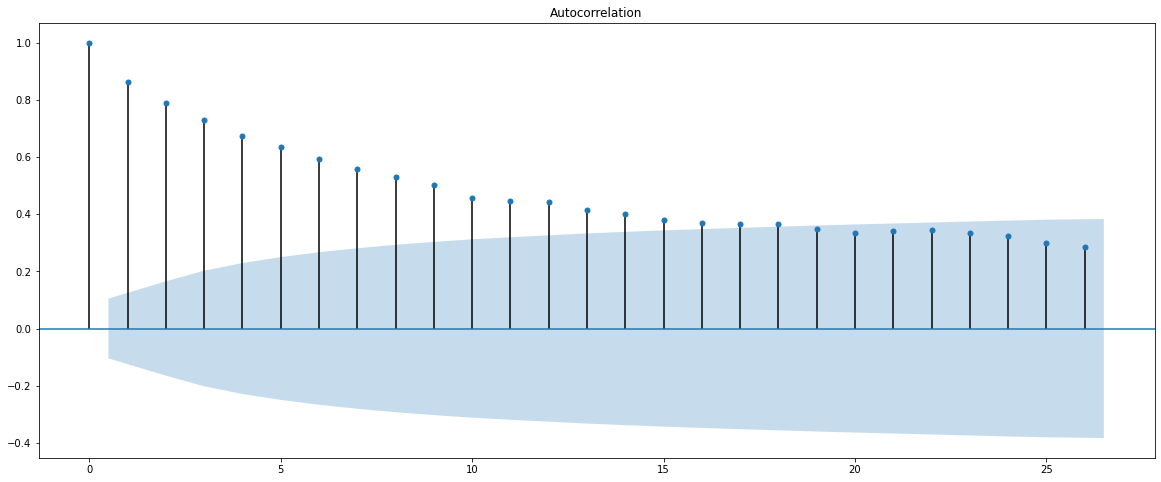

In [43]:
# from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(20, 8))
plot_acf(EM4_cubic,ax=ax)
plt.show()

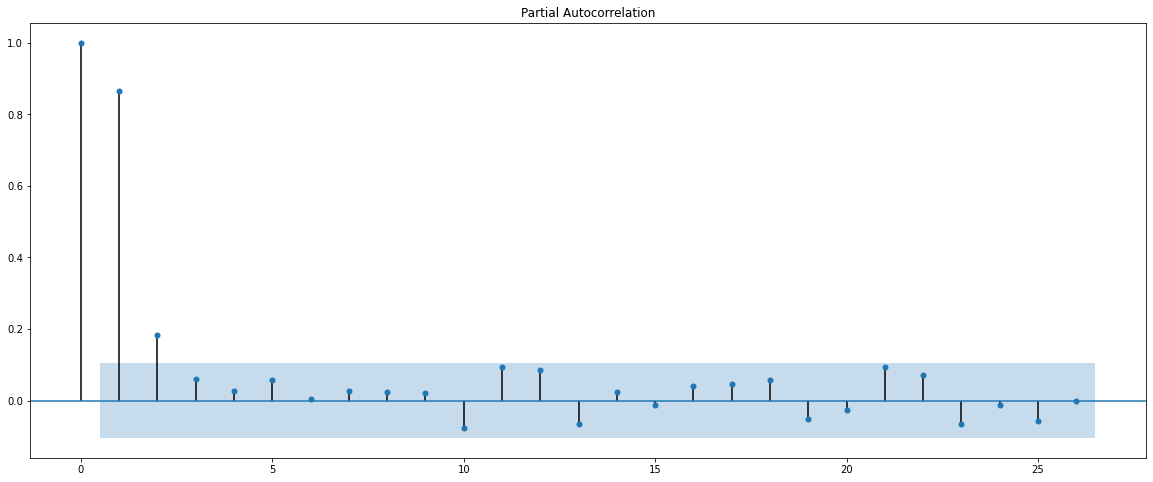

In [44]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_pacf(EM4_cubic,ax=ax)
plt.show()

In [45]:
data1 = EM4_cubic.copy()
data1.head()

,EM4
time,
2020-06-15 01:00:00,363.0
2020-06-15 02:00:00,19.0
2020-06-15 04:00:00,270.0
2020-06-15 05:00:00,250.0
2020-06-15 06:00:00,293.0


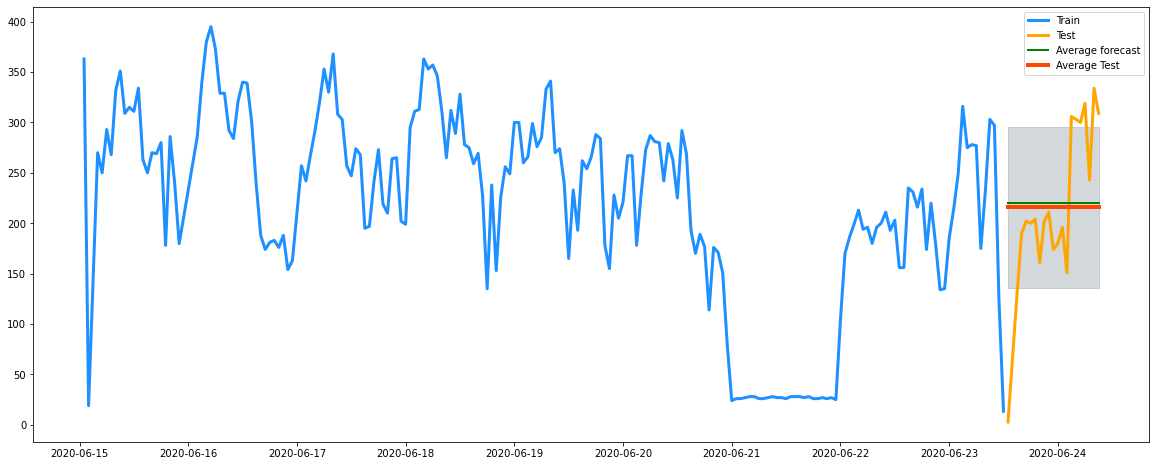

78.13483223613618


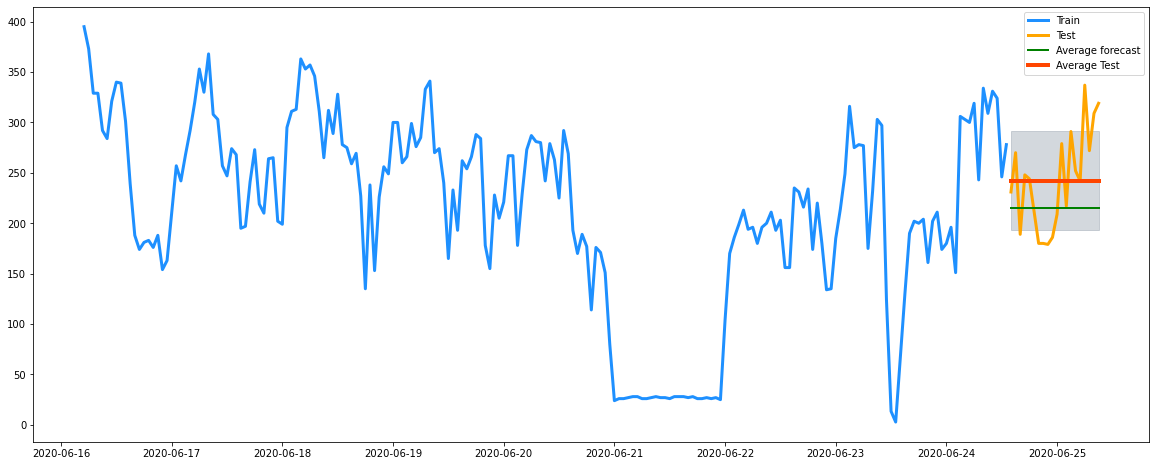

55.044344881713556


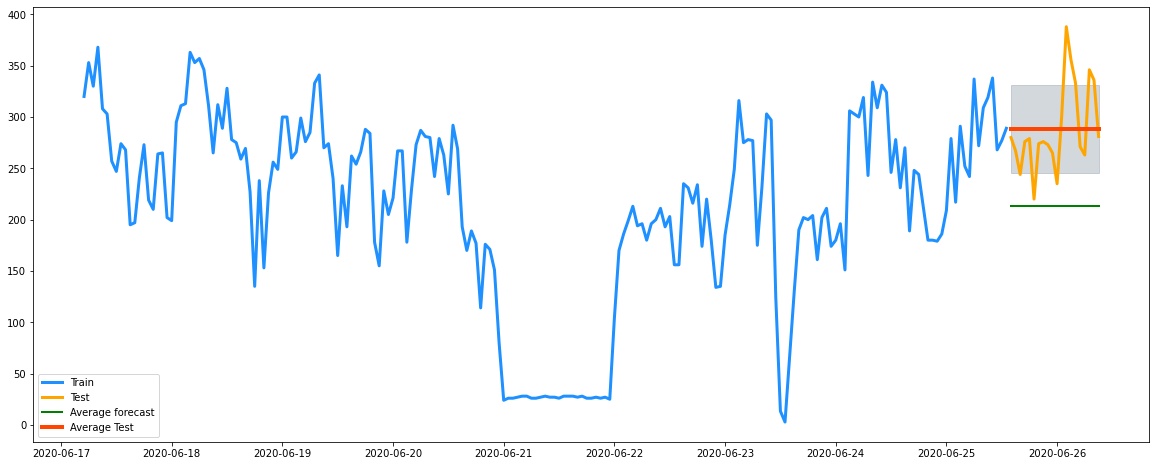

85.3295152337104


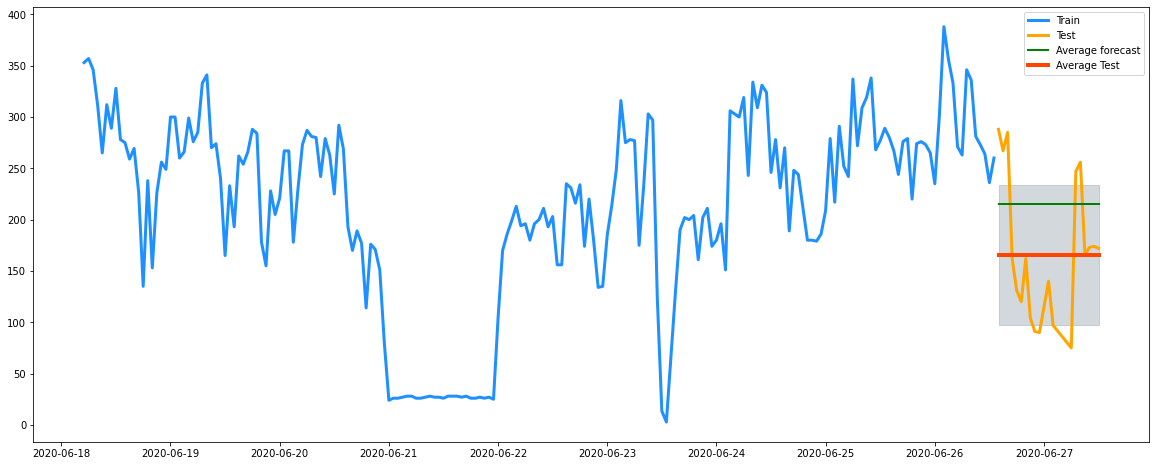

82.80851879219016


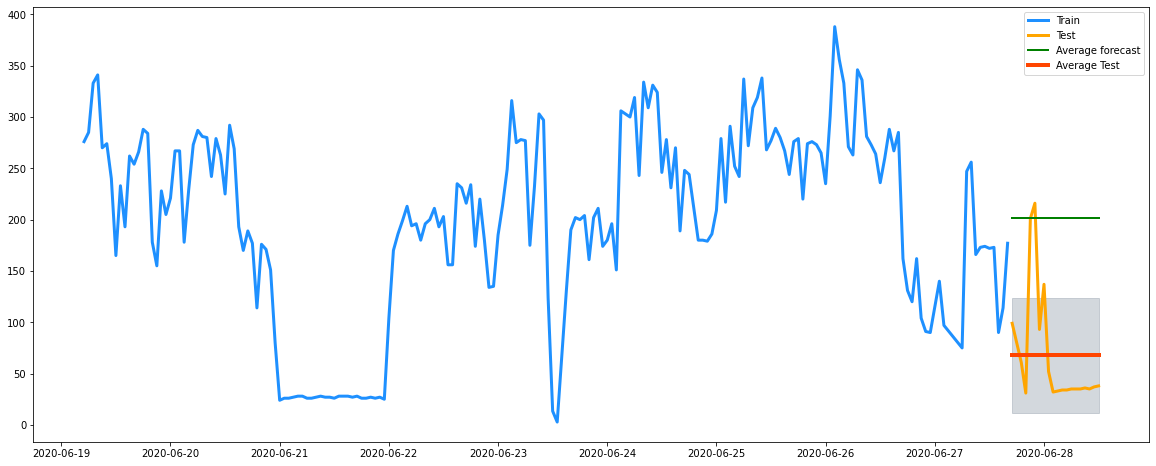

144.46049511627578


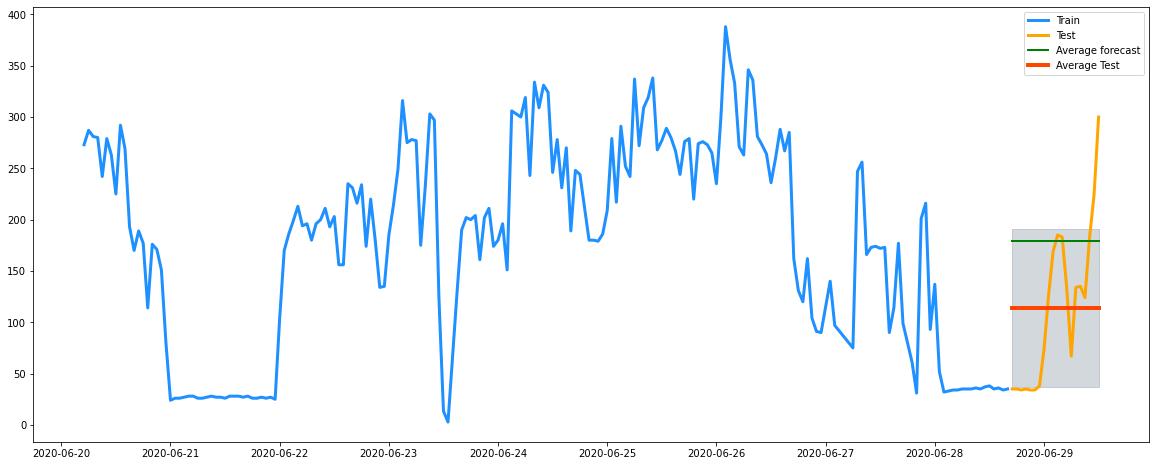

99.66891952616753


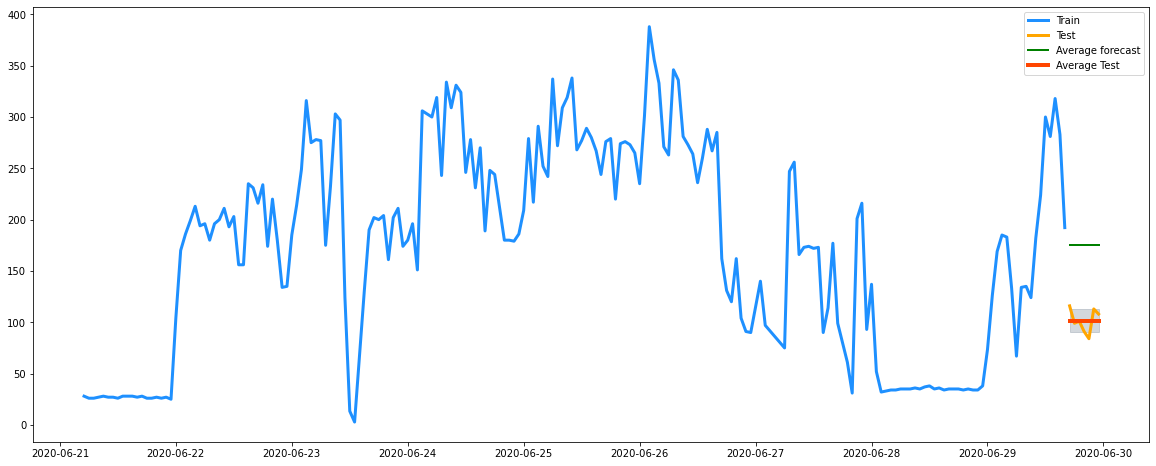

74.04322322126


In [46]:
window=200
offset=20
for i in range(0,len(data1)-200, 24):
    train_new = data1.iloc[i:(window+i)]
    test_new = data1.iloc[(window+i):(window+i+offset)]
    y_hat_avg_new = test_new.copy()
    y_hat_avg_new['avg_forecast']=train_new['EM4'].mean()
    rms1 = sqrt(mean_squared_error(y_hat_avg_new.EM4, y_hat_avg_new.avg_forecast))
    y_hat_avg_new['test_mean'] = test_new['EM4'].mean()
    y_hat_avg_new['test_sd'] = stdev(test_new['EM4'])
    y_hat_avg_new['-SD']=y_hat_avg_new['test_mean']-y_hat_avg_new['test_sd']
    y_hat_avg_new['+SD']=y_hat_avg_new['test_mean']+y_hat_avg_new['test_sd']
    plt.figure(figsize=(20,8))
    plt.plot(train_new['EM4'], label='Train', lw = 3,color='dodgerblue')
    plt.plot(test_new['EM4'], label='Test', lw = 3,color='orange')
    plt.plot(y_hat_avg_new['avg_forecast'], label='Average forecast', lw = 2,color='green')
    plt.plot(y_hat_avg_new['test_mean'], label='Average Test', lw = 4,color='orangered')
    plt.fill_between(y_hat_avg_new.index,y_hat_avg_new['-SD'], y_hat_avg_new['+SD'],alpha=0.3,color='slategrey')
    plt.legend(loc='best')
    plt.show()
    print(rms1)

In [47]:
# df = pd.DataFrame()
# window=200
# offset=20
# for i in range(0,len(data1)-200, 24):
#     train_new = data1.iloc[i:(window+i)]
#     test_new = data1.iloc[(window+i):(window+i+offset)]
#     y_hat_avg_new = test_new.copy()
#     y_hat_avg_new['moving_avg_forecast'] = train_new['EM4'].rolling(2).mean().iloc[-1]
#     rms2 = sqrt(mean_squared_error(y_hat_avg_new.EM4, y_hat_avg_new.moving_avg_forecast))
#     y_hat_avg_new['test_mean'] = test_new['EM4'].mean()
#     y_hat_avg_new['test_sd'] = stdev(test_new['EM4'])
#     y_hat_avg_new['-SD']=y_hat_avg_new['test_mean']-y_hat_avg_new['test_sd']
#     y_hat_avg_new['+SD']=y_hat_avg_new['test_mean']+y_hat_avg_new['test_sd']
#     plt.figure(figsize=(20,8))
#     plt.plot(train_new['EM4'], label='Train', lw = 3,color='dodgerblue')
#     plt.plot(test_new['EM4'], label='Test', lw = 3,color='orange')
#     plt.plot(y_hat_avg_new['moving_avg_forecast'], label='Moving Average', lw = 2,color='green')
#     plt.plot(y_hat_avg_new['test_mean'], label='Average Test', lw = 4,color='orangered')
#     plt.fill_between(y_hat_avg_new.index,y_hat_avg_new['-SD'], y_hat_avg_new['+SD'],alpha=0.3,color='slategrey')
#     plt.legend(loc='best')
#     plt.show()
#     print(rms2)

In [48]:
# df = pd.DataFrame()
# window=200
# offset=20
# for i in range(0,len(data1)-200, 24):
#     train_new = data1.iloc[i:(window+i)]
#     test_new = data1.iloc[(window+i):(window+i+offset)]
#     y_hat_avg_new = test_new.copy()
#     y_hat_avg_new['naive'] = train_new['EM4'][len(train_new)-1]
#     rms3 = sqrt(mean_squared_error(y_hat_avg_new.EM4, y_hat_avg_new.naive))
#     y_hat_avg_new['test_mean'] = test_new['EM4'].mean()
#     y_hat_avg_new['test_sd'] = stdev(test_new['EM4'])
#     y_hat_avg_new['-SD']=y_hat_avg_new['test_mean']-y_hat_avg_new['test_sd']
#     y_hat_avg_new['+SD']=y_hat_avg_new['test_mean']+y_hat_avg_new['test_sd']
#     plt.figure(figsize=(20,8))
#     plt.plot(train_new['EM4'], label='Train', lw = 3,color='dodgerblue')
#     plt.plot(test_new['EM4'], label='Test', lw = 3,color='orange')
#     plt.plot(y_hat_avg_new['naive'], label='Naive', lw = 2,color='green')
#     plt.plot(y_hat_avg_new['test_mean'], label='Average Test', lw = 4,color='orangered')
#     plt.fill_between(y_hat_avg_new.index,y_hat_avg_new['-SD'], y_hat_avg_new['+SD'],alpha=0.3,color='slategrey')
#     plt.legend(loc='best')
#     plt.show()
#     print(rms3)

In [49]:
# df = pd.DataFrame()
# window=200
# offset=20
# for i in range(0,len(data1)-200, 24):
#     train_new = data1.iloc[i:(window+i)]
#     test_new = data1.iloc[(window+i):(window+i+offset)]
#     y_hat_avg_new = test_new.copy()
#     fit2 = SimpleExpSmoothing(np.asarray(train_new['EM4'])).fit(smoothing_level = 0.9, optimized = False)
#     y_hat_avg_new['SES'] = fit2.forecast(len(test_new))
#     rms4 = sqrt(mean_squared_error(test_new.EM4, y_hat_avg_new.SES))
#     y_hat_avg_new['test_mean'] = test_new['EM4'].mean()
#     y_hat_avg_new['test_sd'] = stdev(test_new['EM4'])
#     y_hat_avg_new['-SD']=y_hat_avg_new['test_mean']-y_hat_avg_new['test_sd']
#     y_hat_avg_new['+SD']=y_hat_avg_new['test_mean']+y_hat_avg_new['test_sd']
#     plt.figure(figsize=(20,8))
#     plt.plot(train_new['EM4'], label='Train', lw = 3,color='dodgerblue')
#     plt.plot(test_new['EM4'], label='Test', lw = 3,color='orange')
#     plt.plot(y_hat_avg_new['SES'], label='SES', lw = 2,color='green')
#     plt.plot(y_hat_avg_new['test_mean'], label='Average Test', lw = 4,color='orangered')
#     plt.fill_between(y_hat_avg_new.index,y_hat_avg_new['-SD'], y_hat_avg_new['+SD'],alpha=0.3,color='slategrey')
#     plt.legend(loc='best')
#     plt.show()
#     print(rms4)

In [50]:
# df = pd.DataFrame()
# window=200
# offset=20
# for i in range(0,len(data1)-200, 24):
#     train_new = data1.iloc[i:(window+i)]
#     test_new = data1.iloc[(window+i):(window+i+offset)]
#     y_hat_avg_new = test_new.copy()
#     fit1 = Holt(np.asarray(train_new['EM4'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
#     y_hat_avg_new['Holt_linear'] = fit1.forecast(len(test_new))
#     rms5 = sqrt(mean_squared_error(test_new.EM4, y_hat_avg_new.Holt_linear))
#     y_hat_avg_new['test_mean'] = test_new['EM4'].mean()
#     y_hat_avg_new['test_sd'] = stdev(test_new['EM4'])
#     y_hat_avg_new['-SD']=y_hat_avg_new['test_mean']-y_hat_avg_new['test_sd']
#     y_hat_avg_new['+SD']=y_hat_avg_new['test_mean']+y_hat_avg_new['test_sd']
#     plt.figure(figsize=(20,8))
#     plt.plot(train_new['EM4'], label='Train', lw = 3,color='dodgerblue')
#     plt.plot(test_new['EM4'], label='Test', lw = 3,color='orange')
#     plt.plot(y_hat_avg_new['Holt_linear'], label='Holt Linear', lw = 2,color='green')
#     plt.plot(y_hat_avg_new['test_mean'], label='Average Test', lw = 4,color='orangered')
#     plt.fill_between(y_hat_avg_new.index,y_hat_avg_new['-SD'], y_hat_avg_new['+SD'],alpha=0.3,color='slategrey')
#     plt.legend(loc='best')
#     plt.show()
#     print(rms5)

In [51]:
# df = pd.DataFrame()
# window=200
# offset=20
# for i in range(0,len(data1)-200, 24):
#     train_new = data1.iloc[i:(window+i)]
#     test_new = data1.iloc[(window+i):(window+i+offset)]
#     y_hat_avg_new = test_new.copy()
#     fit1 = ExponentialSmoothing(np.asarray(train_new['EM4']) ,seasonal_periods = 12, trend='add', seasonal='add').fit()
#     y_hat_avg_new['Holt_Winter'] = fit1.forecast(len(test_new))
#     rms6 = sqrt(mean_squared_error(test_new.EM4, y_hat_avg_new.Holt_Winter))
#     y_hat_avg_new['test_mean'] = test_new['EM4'].mean()
#     y_hat_avg_new['test_sd'] = stdev(test_new['EM4'])
#     y_hat_avg_new['-SD']=y_hat_avg_new['test_mean']-y_hat_avg_new['test_sd']
#     y_hat_avg_new['+SD']=y_hat_avg_new['test_mean']+y_hat_avg_new['test_sd']
#     plt.figure(figsize=(20,8))
#     plt.plot(train_new['EM4'], label='Train', lw = 3,color='dodgerblue')
#     plt.plot(test_new['EM4'], label='Test', lw = 3,color='orange')
#     plt.plot(y_hat_avg_new['Holt_Winter'], label='Holt_Winter', lw = 2,color='green')
#     plt.plot(y_hat_avg_new['test_mean'], label='Average Test', lw = 4,color='orangered')
#     plt.fill_between(y_hat_avg_new.index,y_hat_avg_new['-SD'], y_hat_avg_new['+SD'],alpha=0.3,color='slategrey')
#     plt.legend(loc='best')
#     plt.show()   
#     print(rms6)

In [52]:
# df = pd.DataFrame()
# window=200
# offset=20
# for i in range(0,len(data1)-200, 24):
#     train_new = data1.iloc[i:(window+i)]
#     test_new = data1.iloc[(window+i):(window+i+offset)]
#     y_hat_avg_new = test_new.copy()
#     y_hat_avg_new['avg_forecast']=train_new['EM4'].mean()
#     rms1 = sqrt(mean_squared_error(y_hat_avg_new.EM4, y_hat_avg_new.avg_forecast))
#     y_hat_avg_new['moving_avg_forecast'] = train_new['EM4'].rolling(2).mean().iloc[-1]
#     rms2 = sqrt(mean_squared_error(y_hat_avg_new.EM4, y_hat_avg_new.moving_avg_forecast))
#     y_hat_avg_new['naive'] = train_new['EM4'][len(train_new)-1]
#     rms3 = sqrt(mean_squared_error(y_hat_avg_new.EM4, y_hat_avg_new.naive))
#     fit2 = SimpleExpSmoothing(np.asarray(train_new['EM4'])).fit(smoothing_level = 0.8, optimized = False)
#     y_hat_avg_new['SES'] = fit2.forecast(len(test_new))
#     rms4 = sqrt(mean_squared_error(test_new.EM4, y_hat_avg_new.SES))
#     fit1 = Holt(np.asarray(train_new['EM4'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
#     y_hat_avg_new['Holt_linear'] = fit1.forecast(len(test_new))
#     rms5 = sqrt(mean_squared_error(test_new.EM4, y_hat_avg_new.Holt_linear))
#     fit1 = ExponentialSmoothing(np.asarray(train_new['EM4']) ,seasonal_periods = 12, trend='add', seasonal='add').fit()
#     y_hat_avg_new['Holt_Winter'] = fit1.forecast(len(test_new))
#     rms6 = sqrt(mean_squared_error(test_new.EM4, y_hat_avg_new.Holt_Winter))
#     x = pd.DataFrame([rms1, rms2, rms3, rms4, rms5, rms6]).T
#     df = df.append(x)
    
    
# df.columns=["Simple Average","Moving Average","Naive","SES","Holt's Linear","Holt's Winter"] 

In [53]:
df = pd.DataFrame()
window=200
offset=20
for i in range(0,len(data1)-200, 24):
    train_new = data1.iloc[i:(window+i)]
    test_new = data1.iloc[(window+i):(window+i+offset)]
    y_hat_avg_new = test_new.copy()
    y_hat_avg_new['avg_forecast']=train_new['EM4'].mean()
    rms1 = sqrt(mean_squared_error(y_hat_avg_new.EM4, y_hat_avg_new.avg_forecast))

In [54]:
df = pd.DataFrame()
window=200
offset=20
for i in range(0,len(data1)-200, 24):
    train_new = data1.iloc[i:(window+i)]
    test_new = data1.iloc[(window+i):(window+i+offset)]
    y_hat_avg_new = test_new.copy()
    y_hat_avg_new['moving_avg_forecast'] = train_new['EM4'].rolling(2).mean().iloc[-1]
    rms2 = sqrt(mean_squared_error(y_hat_avg_new.EM4, y_hat_avg_new.moving_avg_forecast))

In [55]:
df = pd.DataFrame()
window=200
offset=20
for i in range(0,len(data1)-200, 24):
    train_new = data1.iloc[i:(window+i)]
    test_new = data1.iloc[(window+i):(window+i+offset)]
    y_hat_avg_new = test_new.copy()
    y_hat_avg_new['naive'] = train_new['EM4'][len(train_new)-1]
    rms3 = sqrt(mean_squared_error(y_hat_avg_new.EM4, y_hat_avg_new.naive))

In [56]:
from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot
series = read_csv('sunspots.csv', header=0, index_col=0)
X = series.values
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    pyplot.subplot(310 + index)
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    index += 1
pyplot.show()

FileNotFoundError: [Errno 2] File sunspots.csv does not exist: 'sunspots.csv'

In [ ]:
# t = pd.DataFrame(df.mean())
# t = t.rename(columns={0: 'RMS'})
# fig, ax1 = plt.subplots(figsize = (20,8))
# ax1.bar(t.index,t.RMS, color = 'grey')

In [ ]:
# df = pd.DataFrame()
# window=200
# offset=20
# dictl = dict()
# minimum = 0
# for i in range(0,len(data1)-200, 24):
#     train = data1.iloc[i:(window+i)]
#     test = data1.iloc[(window+i):(window+i+offset)]
#     #y_hat_avg_new = test_new.copy()
 
#     for j in range(2,100):
#         fit1 = ExponentialSmoothing(np.asarray(train['EM4']) ,seasonal_periods = j, trend='add', seasonal='add').fit()
#         x = fit1.forecast(len(test))
#         rms = sqrt(mean_squared_error(test.EM4, x))
#         dictl.update({j:rms})
#     print(min(dictl.items(), key=lambda x: x[1]))

In [ ]:
# z

In [ ]:
# statistics.mean(z)

In [ ]:
# l = [1,2,3,4,5]

In [ ]:
# min(l)

In [2]:
pd.datetime.now()

NameError: name 'pd' is not defined